# New York 
## Contents
- [Imports](#Data-Dictionary)
- [Regression Modeling](#Regression-Modeling)  
- [Classification Modeling](#Classification-Modeling)  

# Imports

In [3]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm  import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer, QuantileTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier

In [4]:
# Import the Texas data and sae to a dataframe.
df = pd.read_csv('../data/cleaned_engineered_ny.csv')

In [5]:
# Display the first few rows of the dataframe.
df.head(2)

,county_state,total_cases,total_fatalities,death_rate,total_tests,race_pop,race_pop_hispanic_or_latino_of_any_race,race_pop_white_alone,race_pop_black_or_african_american_alone,race_pop_american_indian_and_alaska_native_alone,...,percent_race_pop_other,percent_race_pop_minority,percent_sex_age_pop_0_to_44,percent_sex_age_pop_45_to_74,percent_sex_age_pop_75_and_over,percent_sex_age_pop_0_to_64,percent_sex_age_pop_65_and_over,percent_sex_age_pop_0_to_35,percent_sex_age_pop_35_to_59,percent_sex_age_pop_60_to_84
0,"Albany County, New York",3577.0,128.0,0.035784,176101,307426,17925,223319,35930,322,...,0.033780,0.273585,0.578233,0.351571,0.070196,0.839259,0.160741,0.465114,0.309974,0.200861
1,"Allegany County, New York",271.0,9.0,0.033210,24790,47025,744,44391,639,133,...,0.015481,0.056013,0.558830,0.365019,0.076151,0.820436,0.179564,0.459989,0.294163,0.222243


# Regression Modeling

## Explainable Model: GridSearchCV with Quantile, SelectKBest, Ridge: 81%

In [65]:
# Assign our features to X.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people'
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [66]:
# Display the shape of the training data.
X_train.shape

(46, 20)

In [67]:
X_test.shape

(16, 20)

In [68]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,21),
    'ridge__alpha': [.1, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [69]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fd466b79d40>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10],
                         'selectkbest__k': range(1, 21)},
             scoring='r2')

In [70]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 1, 'selectkbest__k': 20}

In [71]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.8127548012278845

In [72]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.7981636550361271

In [73]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print('RMSE of Model:', mean_squared_error(y_test, y_preds, squared=False))

RMSE of Model: 0.4219435264792064


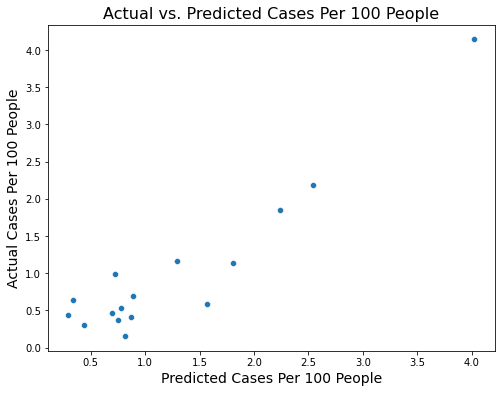

In [74]:
# Plot the predicted sale price versus the actual 'cases_per_100_people'
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('Actual vs. Predicted Cases Per 100 People', fontsize=16)
plt.xlabel('Predicted Cases Per 100 People', fontsize=14)
plt.ylabel('Actual Cases Per 100 People', fontsize=14);

In [75]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()
features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [76]:
features = X_train.columns[features==True]

In [77]:
features

Index(['inc_per_capita_inc_dol', 'obes_percent',
       'percent_race_pop_hispanic_or_latino_of_any_race',
       'percent_race_pop_black_or_african_american_alone',
       'percent_race_pop_american_indian_and_alaska_native_alone',
       'percent_race_pop_two_or_more_races', 'percent_race_pop_asian_alone',
       'percent_race_pop_white_alone', 'percent_sex_age_pop_5_to_9',
       'percent_sex_age_pop_10_to_14', 'percent_sex_age_pop_15_to_19',
       'percent_sex_age_pop_20_to_24', 'percent_sex_age_pop_25_to_34',
       'percent_sex_age_pop_35_to_44', 'percent_sex_age_pop_45_to_74',
       'percent_sex_age_pop_75_and_over', 'percent_sex_age_pop_male',
       'percent_health_ins_noninst_pop_cov_no', 'pop_density',
       'tests_per_100_people'],
      dtype='object')

In [78]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['ridge'].coef_

In [79]:
coefs.shape

(20,)

In [80]:
coefs

array([ 0.49260488, -0.30964615,  0.55470188,  1.00757562,  0.18945854,
       -0.59379441,  0.31269518, -0.58044205,  0.26696078,  0.47118766,
       -0.03642773, -0.44546372, -0.80852369,  0.02082538, -0.37512381,
       -0.09183536,  0.01437204,  0.69536238,  0.61908264,  0.5018227 ])

In [81]:
coef_df = pd.DataFrame(list(zip(features, coefs)), columns=['Feature', 'cases_per_100_people'])
coef_df = coef_df.set_index('Feature')
coef_df = coef_df.sort_values(by='cases_per_100_people', ascending=False)

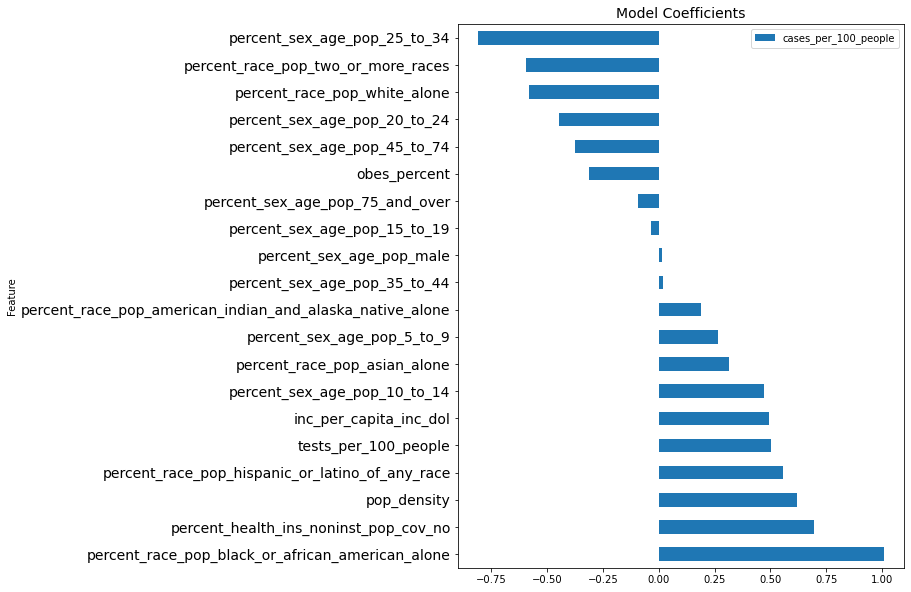

In [83]:
# Plot the datatframe of the top 10 word and their coefficients.
coef_df.plot(kind = 'barh', figsize=(8,10))
plt.title('Model Coefficients', fontsize=14)
plt.yticks(fontsize=14);

## Blackbox Model: Quantile, Polynomial, Gridsearch, Ridge: 81%

In [97]:
# Assign our features to X.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people',
]]

y = df['cases_per_100_people']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [98]:
# Display the shape of the training data.
X_train.shape

(46, 20)

In [99]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(f_regression), Ridge(max_iter=20_000))

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'ridge__alpha': [.1, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, scoring='r2', cv=10, n_jobs=-1)

In [100]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7fd466b79d40>)),
                                       ('ridge', Ridge(max_iter=20000))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': [0.1, 1, 10],
                         'selectkbest__k': range(1, 300)},
             scoring='r2')

In [101]:
# Display the best parameters.
gs.best_params_

{'ridge__alpha': 1, 'selectkbest__k': 112}

In [102]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.8074356319024936

In [103]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.9143186223474196

In [104]:
# Calculate the RMSE for the model.
y_preds = gs.predict(X_test)
print('RMSE of Model:', mean_squared_error(y_test, y_preds, squared=False))

RMSE of Model: 0.42789473954283846


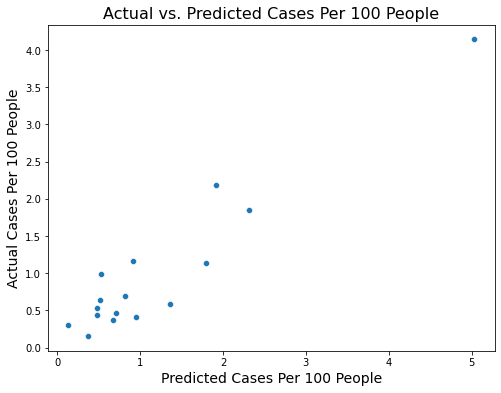

In [105]:
# Plot the predicted sale price versus the actual sale price
plt.figure(figsize=(8,6))
sns.scatterplot(y_preds, y_test)
plt.title('Actual vs. Predicted Cases Per 100 People', fontsize=16)
plt.xlabel('Predicted Cases Per 100 People', fontsize=14)
plt.ylabel('Actual Cases Per 100 People', fontsize=14);

# Classification Modeling

## Simple(r) Model: GridSearchCV with Classifier: 94% (baseline 81)

In [108]:
# Assign our features to X.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people',
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [109]:
y_test.value_counts(normalize=True)

1    0.8125
3    0.1250
2    0.0625
Name: covid_severity, dtype: float64

In [110]:
# Display the shape of the training data.
X_train.shape

(46, 20)

In [111]:
X_test.shape

(16, 20)

In [112]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,21),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [113]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 21)})

In [114]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 10, 'selectkbest__k': 2}

In [115]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.9375

In [116]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.9565217391304348

In [117]:
y_preds = gs.predict(X_test)

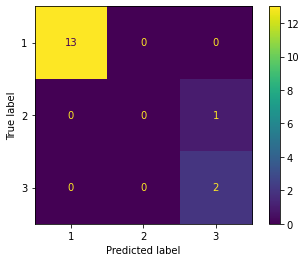

In [118]:
# Plot the predicted labels versus the actual labels.
plot_confusion_matrix(gs, X_test, y_test);

In [119]:
# Extract a boolean matrix of features selectkbest used in the best model.
features = gs.best_estimator_.named_steps['selectkbest'].get_support()
features

array([False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [120]:
features = X_train.columns[features==True]

In [121]:
# Extract the coefficients for the features used in the best model.
coefs = gs.best_estimator_.named_steps['logisticregression'].coef_

In [122]:
coefs.shape

(3, 2)

In [123]:
coef1 = coefs[0]
coef2 = coefs[1]
coef3 = coefs[2]

In [124]:
pd.DataFrame(list(zip(features, coef1)), columns=['Feature', 'covid_severity_1'])

,Feature,covid_severity_1
0,percent_race_pop_hispanic_or_latino_of_any_race,-4.174190
1,percent_race_pop_white_alone,3.752613


In [125]:
pd.DataFrame(list(zip(features, coef2)), columns=['Feature', 'covid_severity_2'])

,Feature,covid_severity_2
0,percent_race_pop_hispanic_or_latino_of_any_race,1.420183
1,percent_race_pop_white_alone,-1.015642


In [126]:
pd.DataFrame(list(zip(features, coef3)), columns=['Feature', 'covid_severity_3'])

,Feature,covid_severity_3
0,percent_race_pop_hispanic_or_latino_of_any_race,2.754008
1,percent_race_pop_white_alone,-2.736970


## Blackbox Model: Quantile, Polynomial, Gridsearch, Classifier: 81% (baseline 81)

In [127]:
# Assign our features to X.
X = df[[
    'inc_per_capita_inc_dol',
    'obes_percent',
    'percent_race_pop_hispanic_or_latino_of_any_race',
    'percent_race_pop_black_or_african_american_alone',
    'percent_race_pop_american_indian_and_alaska_native_alone',
    'percent_race_pop_two_or_more_races',
    'percent_race_pop_asian_alone',
    'percent_race_pop_white_alone',    
    'percent_sex_age_pop_5_to_9',
    'percent_sex_age_pop_10_to_14',
    'percent_sex_age_pop_15_to_19',
    'percent_sex_age_pop_20_to_24',
    'percent_sex_age_pop_25_to_34',
    'percent_sex_age_pop_35_to_44',
    'percent_sex_age_pop_45_to_74',
    'percent_sex_age_pop_75_and_over',
    'percent_sex_age_pop_male',
    'percent_health_ins_noninst_pop_cov_no',
    'pop_density',
    'tests_per_100_people',
]]

y = df['covid_severity']

# Split X and y into train/test groups.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [128]:
# Display the shape of the training data.
X_train.shape

(46, 20)

In [129]:
# Display the shape of the training data.
X_test.shape

(16, 20)

In [130]:
# Create a main pipeline that will contain the dtype pipelines and the estimator.
pipe = make_pipeline(QuantileTransformer(), PolynomialFeatures(), SelectKBest(), LogisticRegression())

# Set parameters for GridSearchCV.
params = {
    'selectkbest__k': range(1,300),
    'logisticregression__C': [.1, .5, 1, 10]
}

# Set up GridSearchCV with the pipe and R2 as the scoring method.
gs = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=-1)

In [131]:
# Call fit on the GridSearchCV object and pass the training  data.
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('quantiletransformer',
                                        QuantileTransformer()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 0.5, 1, 10],
                         'selectkbest__k': range(1, 300)})

In [132]:
# Display the best parameters.
gs.best_params_

{'logisticregression__C': 0.1, 'selectkbest__k': 81}

In [133]:
# Display the score for the test set.
gs.score(X_test, y_test)

0.875

In [134]:
# Display the score for the train set.
gs.score(X_train, y_train)

0.9565217391304348

In [135]:
y_preds = gs.predict(X_test)

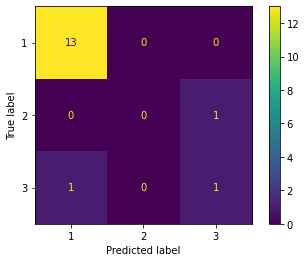

In [136]:
# Plot the predicted labels versus the actual labels.
plot_confusion_matrix(gs, X_test, y_test);